We’ll use a bead-spring polymer as shown in the short trajectory snippet below:

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/traj.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

This polymer has each bead (atom) joined by a harmonic bond, a harmonic angle between each three, and a Lennard-Jones interaction potential. We’ll construct a VAE that can compress the trajectory to some latent space and generate new conformations.

We'll use Input Data & Equivariances to align points from a trajectory. This will then serve as our training data. The space of our problem will be 12 2D vectors. Our system need not be permutation invariant, so we can flatten these vectors into a 24 dimensional input. The code belows loads and aligns the trajectory

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns


###---------Transformation Functions----###
def center_com(paths):
    """Align paths to COM at each frame"""
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms


def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)


def find_principle_axis(points):
    """Compute single principle axis for points"""
    inertia = points.T @ points
    evals, evecs = np.linalg.eigh(inertia)
    # get biggest eigenvalue
    order = np.argsort(evals)
    return evecs[:, order[-1]]


def align_principle(paths, axis_finder=find_principle_axis):
    # This is a degenarate version, I removed mirror disambiguation
    # to make latent space jump less. Data augmentation will
    # have to overcome this issue
    # the code is commented out below
    vecs = [axis_finder(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 1], vecs[:, 0])
    # cross = np.cross(vecs[:,0], vecs[:,1])
    rot_angle = -cur_angle  # - (cross < 0) * np.pi
    rot_mat = make_2drot(rot_angle)
    return paths @ rot_mat


###-----------------------------------###

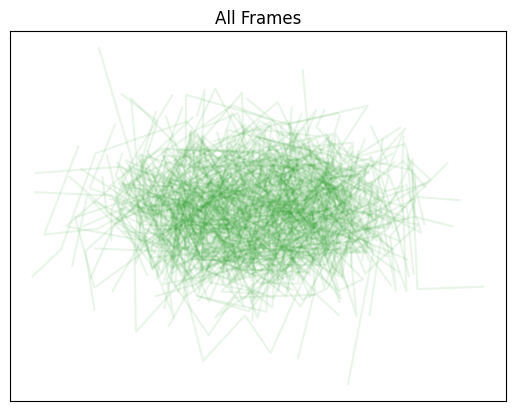

In [5]:
# we'll now load the data and visualise it
urllib.request.urlretrieve(
    "data/long_paths.npz",
    "long_paths.npz",
)
paths = np.load("long_paths.npz")["arr"]
# transform to be rot/trans invariant
data = align_principle(center_com(paths))
cmap = plt.get_cmap("cool")
for i in range(0, data.shape[0], 16):
    plt.plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C2")
plt.title("All Frames")
plt.xticks([])
plt.yticks([])
plt.show()

let’s examine some of the marginals of the data. Marginals mean we’ve transformed (by integration) our probability distribution to be a function of only 1-2 variables so that we can plot nicely. We’ll look at the pairwise distance between points.

<ipython-input-6-eebad2deaeac>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
<ipython-input-6-eebad2deaeac>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
<ipython-input-6

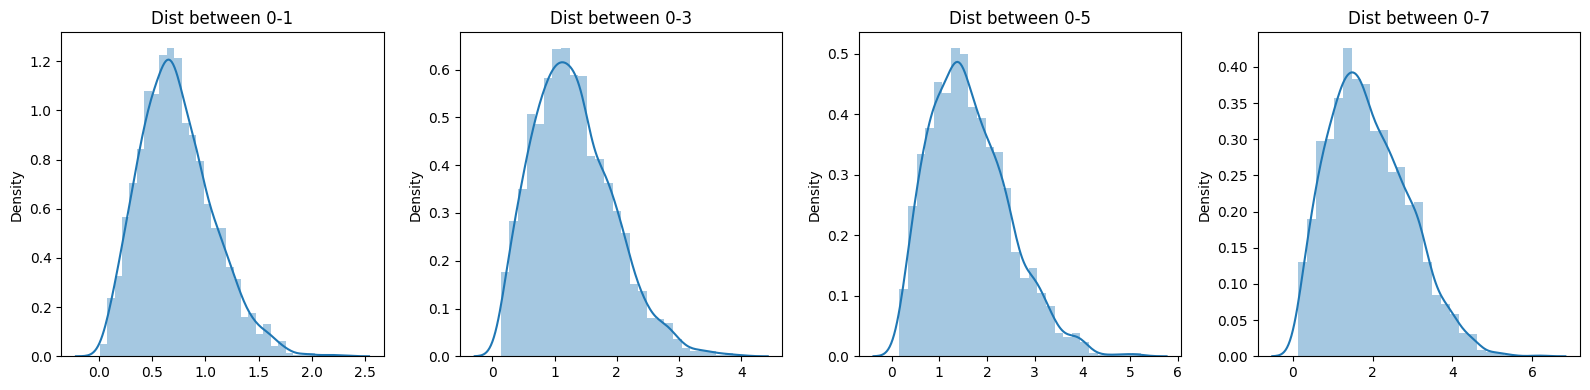

In [6]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
plt.tight_layout()

These look a little like the chi distribution with two degrees of freedom. Notice that the support (x-axis) changes between them though. We’ll keep an eye on these when we evaluate the efficacy of our VAE.

In [7]:
# Now we build the VAE
# We’ll be starting with 4 layers total (3 hidden) with a hidden layer dimension of 256
# Another detail is that we flatten the input/output since the order is preserved and thus we do not worry about separating the x,y dimension out.

import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax
import functools

input_dim = 12 * 2
hidden_units = 256
num_layers = 4
latent_dim = 2


def init_theta(input_dim, hidden_units, latent_dim, num_layers, key, scale=0.1):
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(key=subkey, shape=(hidden_units, latent_dim)) * scale
    b1 = jnp.zeros(hidden_units)
    theta = [(w1, b1)]
    for i in range(1, num_layers - 1):
        key, subkey = jax.random.split(key)
        w = jax.random.normal(key=subkey, shape=(hidden_units, hidden_units)) * scale
        b = jnp.zeros(hidden_units)
        theta.append((w, b))
    key, subkey = jax.random.split(key)
    w = jax.random.normal(key=subkey, shape=(input_dim, hidden_units)) * scale
    b = jnp.zeros(input_dim)
    theta.append((w, b))
    return theta, key


def decoder(z, theta):
    num_layers = len(theta)
    for i in range(num_layers - 1):
        w, b = theta[i]
        z = jax.nn.relu(w @ z + b)
    w, b = theta[-1]
    x = w @ z + b
    return x


def init_phi(input_dim, hidden_units, latent_dim, num_layers, key, scale=0.1):
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(key=subkey, shape=(hidden_units, input_dim)) * scale
    b1 = jnp.zeros(hidden_units)
    phi = [(w1, b1)]
    for i in range(1, num_layers - 1):
        key, subkey = jax.random.split(key)
        w = jax.random.normal(key=subkey, shape=(hidden_units, hidden_units)) * scale
        b = jnp.zeros(hidden_units)
        phi.append((w, b))
    key, subkey = jax.random.split(key)
    w = jax.random.normal(key=subkey, shape=(latent_dim * 2, hidden_units)) * scale
    b = jnp.zeros(latent_dim * 2)
    phi.append((w, b))
    return phi, key


def encoder(x, phi):
    num_layers = len(phi)
    for i in range(num_layers - 1):
        w, b = phi[i]
        x = jax.nn.relu(w @ x + b)
    w, b = phi[-1]
    hz = w @ x + b
    hz = hz.reshape(-1, 2)
    mu = hz[:, 0:1]
    std = jax.nn.softplus(hz[:, 1:2])
    return jnp.concatenate((mu, std), axis=1)

In [9]:
# we define the loss function now

@jax.jit
def loss(x, theta, phi, rng_key):
    """VAE Loss"""
    # reconstruction loss
    sampled_z_params = encoder(x, phi)
    # reparameterization trick
    # we use standard normal sample and multiply by parameters
    # to ensure derivatives correctly propogate to encoder
    sampled_z = (
        jax.random.normal(rng_key, shape=(latent_dim,)) * sampled_z_params[:, 1]
        + sampled_z_params[:, 0]
    )
    # MSE now instead
    xp = decoder(sampled_z, theta)
    rloss = jnp.sum((xp - x) ** 2)
    # LK loss
    klloss = (
        -0.5
        - jnp.log(sampled_z_params[:, 1] + 1e-8)
        + 0.5 * sampled_z_params[:, 0] ** 2
        + 0.5 * sampled_z_params[:, 1] ** 2
    )
    # combined
    return jnp.array([rloss, jnp.mean(klloss)])

def modified_loss(x, theta, phi, rng_key, beta):
    """This loss allows you to vary which term is more important
    with beta. Beta = 0 - all reconstruction, beta = 1 - ELBO"""
    bl = batched_loss(x, theta, phi, rng_key)
    l = bl @ jnp.array([1.0, beta])
    return jnp.mean(l)

# update compiled functions
batched_loss = jax.vmap(loss, in_axes=(0, None, None, None), out_axes=0)
batched_decoder = jax.vmap(decoder, in_axes=(0, None), out_axes=0)
batched_encoder = jax.vmap(encoder, in_axes=(0, None), out_axes=0)
grad = jax.grad(modified_loss, (1, 2))
fast_grad = jax.jit(grad)
fast_loss = jax.jit(batched_loss)

In [10]:
# training the model

batch_size = 32
epochs = 250
key = jax.random.PRNGKey(0)

flat_data = data.reshape(-1, input_dim)
# scramble it
flat_data = jax.random.shuffle(key, flat_data)


opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
theta0, key = init_theta(input_dim, hidden_units, latent_dim, num_layers, key)
phi0, key = init_phi(input_dim, hidden_units, latent_dim, num_layers, key)
opt_state = opt_init((theta0, phi0))
losses = []
# KL/Reconstruction balance
beta = 0.01
for e in range(epochs):
    for bi, i in enumerate(range(0, len(flat_data), batch_size)):
        # make a batch into shape B x 1
        batch = flat_data[i : (i + batch_size)].reshape(-1, input_dim)
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key, beta)
        opt_state = opt_update(bi, grad, opt_state)
    # use large batch for tracking progress
    lvalue = jnp.mean(fast_loss(flat_data[:100], theta, phi, subkey), axis=0)
    losses.append(lvalue)

<ipython-input-10-da4fd086c0d9>:9: DeprecationWarning: jax.random.shuffle is deprecated. Use jax.random.permutation with independent=True.
  flat_data = jax.random.shuffle(key, flat_data)
/usr/local/lib/python3.10/dist-packages/jax/_src/random.py:541: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


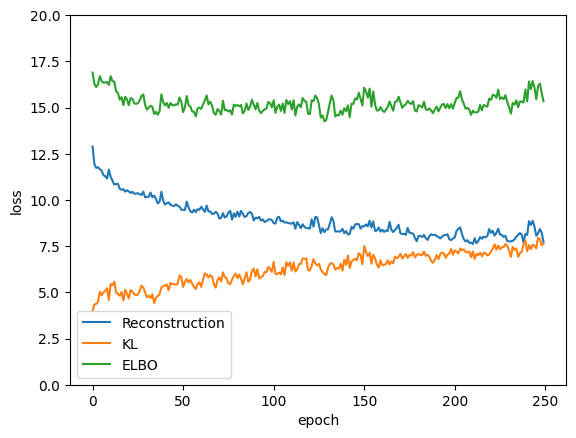

In [11]:
plt.plot([l[0] for l in losses], label="Reconstruction")
plt.plot([l[1] for l in losses], label="KL")
plt.plot([l[1] + l[0] for l in losses], label="ELBO")
plt.legend()
plt.ylim(0, 20)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

this model is undertrained. A latent space of 2, which we chose for plotting convenience, is also probably a little too compressed. Let’s sample a few conformation and see how they look.

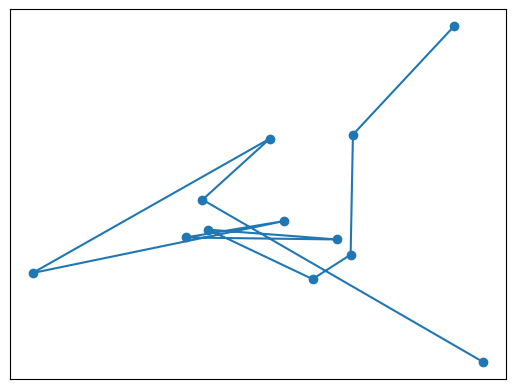

In [12]:
sampled_data = decoder(jax.random.normal(key, shape=[latent_dim]), theta).reshape(-1, 2)
plt.plot(sampled_data[:, 0], sampled_data[:, 1], "-o", alpha=1)
plt.xticks([])
plt.yticks([])
plt.show()

There are three main things to do with a VAE on a trajectory. The first is to go from a trajectory in the feature dimension to the latent dimension. This can simplify analysis of dynamics or act as a reaction coordinate for free energy methods. The second is to generate new conformations. This could be used to fill-in under sampling or perhaps extrapolate to new regions of latent space. We can also use the VAE to examine marginals that are perhaps under-sampled. Finally, we can do optimization on the latent space. For example, we could try to find the most compact structure.

Let’s start by computing a latent trajctory. We're going to load a shorter trajectory which has the frames closer together in time.

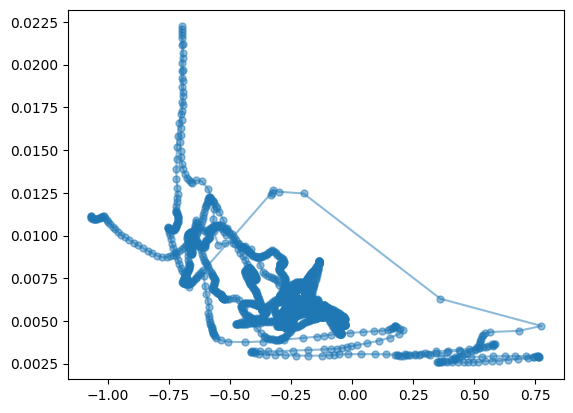

In [13]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/paths.npz", "paths.npz"
)
paths = np.load("paths.npz")["arr"]
short_data = align_principle(center_com(paths))

# get latent params
# throw away standard deviation
latent_traj = batched_encoder(short_data.reshape(-1, input_dim), phi)[:, 0]
plt.plot(latent_traj[:, 0], latent_traj[:, 1], "-o", markersize=5, alpha=0.5)
plt.show()

You can see that the trajectory is relatively continuous, except for a few wide jumps. We’ll see below that this is because the alignment process can have big jumps as our principle axis rapidly moves when the points rearrange.

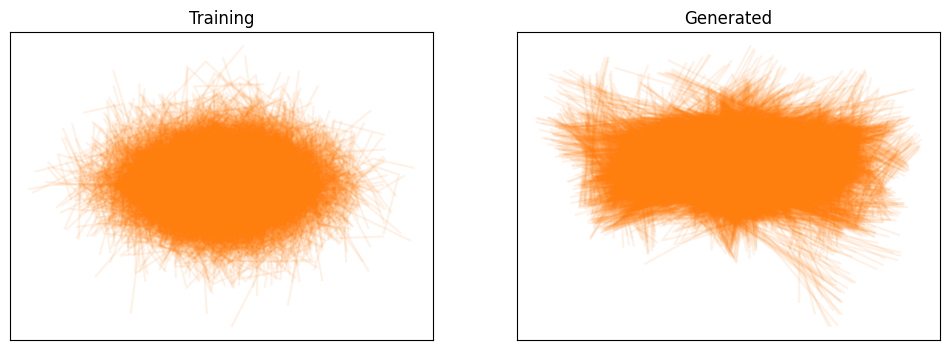

In [14]:
# Lets' see how our samples look

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sampled_data = batched_decoder(
    np.random.normal(size=(data.shape[0], latent_dim)), theta
).reshape(data.shape[0], -1, 2)
for i in range(0, data.shape[0]):
    axs[0].plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C1")
    axs[1].plot(
        sampled_data[i, :, 0], sampled_data[i, :, 1], "-", alpha=0.1, color="C1"
    )
axs[0].set_title("Training")
axs[1].set_title("Generated")
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

<ipython-input-15-79f22a5f2098>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
<ipython-input-15-79f22a5f2098>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
<ipython-input-15-79f22a5f2098>:6: UserWarning: 

`distplot` is 

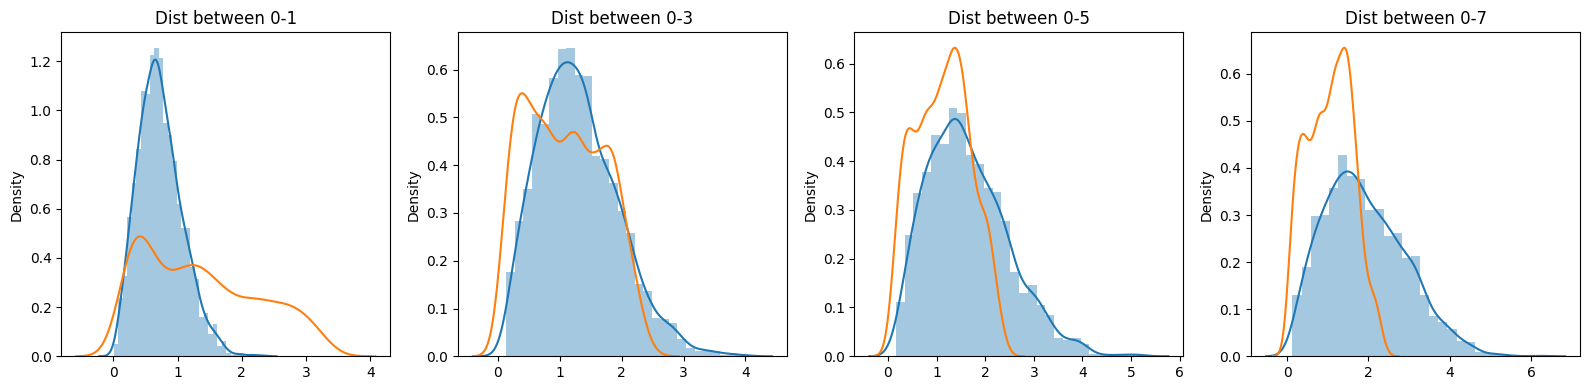

In [15]:
# Let's examine the marginals

fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
    sns.distplot(
        np.linalg.norm(sampled_data[:, 0] - sampled_data[:, j], axis=1),
        ax=axs[i],
        hist=False,
    )
plt.tight_layout()

We can see that there are some issues here as well. Remember that our latent space is quite small: 2D. So we should not be that surprised that we’re losing information from our 24D input space.

 let us examine how we can optimize in the latent space. Let’s say we want to find the most compact structure. We’ll define our loss function as the radius of gyration and take its derivative with respect to z.

 Our generated samples are, by definition, centered at the origin though so we do not need to worry about center of mass. We want to take derivatives in z, but need samples in x to compute radius of gyration. We use the decoder to get an x and can propagate derivatives through it, because it is a differentiable neural network.

In [16]:
def rg_loss(z):
    x = decoder(z, theta).reshape(-1, 2)
    rg = jnp.sum(x**2)
    return jnp.sqrt(rg)


rg_grad = jax.jit(jax.grad(rg_loss))

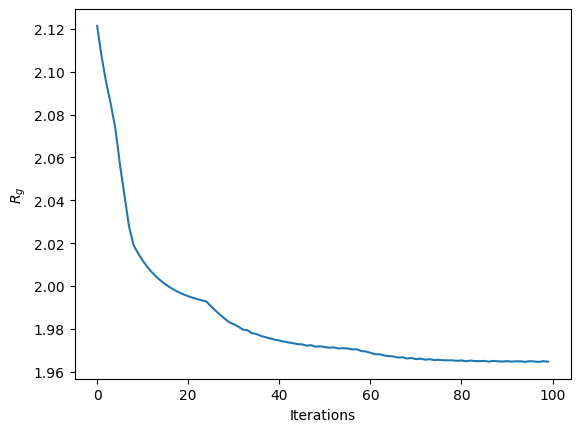

In [17]:
# Now we will find the z that minimizes the radius of gyration by using gradient descent with the derivative.

z = jax.random.normal(key, shape=[latent_dim])
losses = []
eta = 1e-2
for i in range(100):
    losses.append(rg_loss(z))
    g = rg_grad(z)
    z -= eta * g
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("$R_g$")
plt.show()

We have a z with a very low radius of gyration. How good is it? Well, we can also see what was the lowest radius of gyration observed structure in our trajectory. We compare them below.

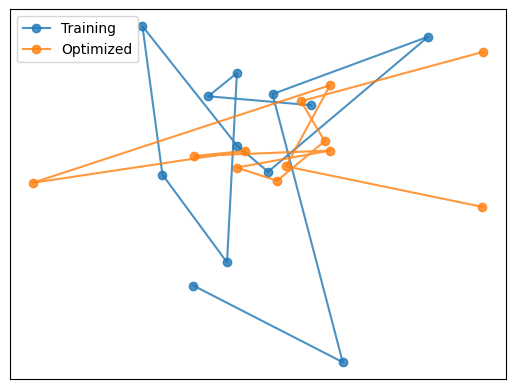

In [18]:
# get min from training
train_rgmin = np.argmin(np.sum(data**2, axis=(1, 2)))
# use new z
opt_rgmin = decoder(z, theta).reshape(-1, 2)
plt.plot(
    data[train_rgmin, :, 0], data[train_rgmin, :, 1], "o-", label="Training", alpha=0.8
)
plt.plot(opt_rgmin[:, 0], opt_rgmin[:, 1], "o-", label="Optimized", alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

What is remarkable about this is that the optimized one has no overlaps and still reasonable bond-lengths. It is also more compact than the lowest radius of gyration found in the training example.